In [1]:
import pandas as pd

import plotly.express as px

pd.options.plotting.backend = "plotly"
from IPython.core.display import display, HTML

# display(HTML("<style>.container { width:75% !important; }</style>"))
import yaml
import os
import base64

local_path = '/home/v.baydin/.secrets/'
file = 'tlinc-staas-ro.yaml.b64'
sec = yaml.load(base64.b64decode(open(os.path.join(local_path, file), 'r').read().encode()), Loader=yaml.BaseLoader)

storage_options = {
    "key": sec['S3_USER'],
    "secret": sec['S3_PASSWORD'],
    "client_kwargs": {
        "endpoint_url": "https://staas.s7.aero",
    },
}

# Загрузка данных
Отрезаем, начиная с 1 июня 2021

In [ ]:
start_date = '2021-06-01'
df = pd.read_parquet(f's3://tlinc-storage/retail/ancillary_stats_from_june_2020.parquet',
                     storage_options=storage_options, engine='pyarrow'
                     )

df = df[df.product_creation_date >= start_date]
stats = pd.read_parquet('s3://tlinc-storage/retail/agg_stat_breakdown_ibe3_from_june_2020_day_extracted.parquet',
                        storage_options=storage_options, engine='pyarrow')
stats.loc[:, 'product_creation_date'] = pd.to_datetime(stats.product_creation_date)
stats = stats[stats.product_creation_date > start_date]
segments_sold_per_day = stats.groupby('product_creation_date')['sum_seg_count'].agg('sum')

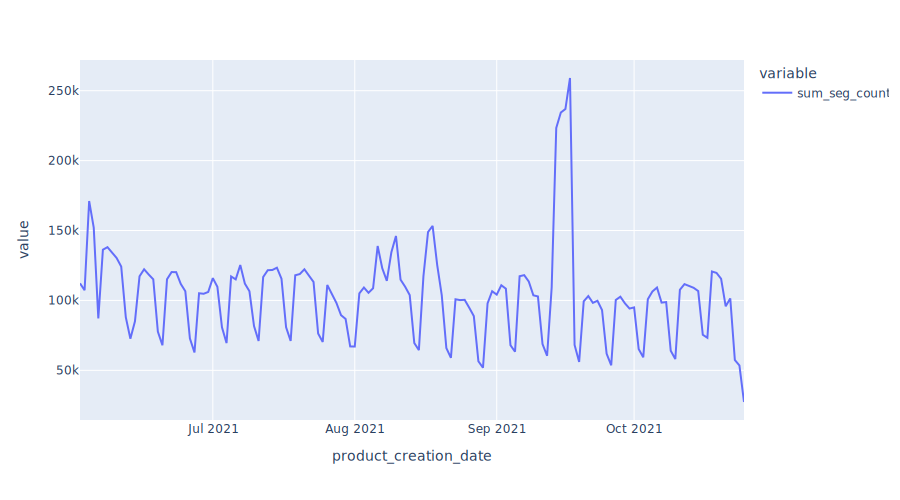

In [16]:
fig = segments_sold_per_day.plot()
fig.update_layout(width=900)
fig.show(renderer='svg')

На графике суммарных продаж пассажиросегментов видно недельные тренды + распродажу от 12 сентября
# Фильтруем редкие группы

Назначаем вместо пустот в departure и arrival — XXX

Оставляем группы, где есть хотя бы 1000 продаж за рассматриваемый период

In [6]:
df = df[df.product_creation_date < df.product_creation_date.max()]

for col in df.columns:
    print(col, sum(df[col].isna()))

df['departure'] = df['departure'].fillna('XXX')
df['arrival'] = df['arrival'].fillna('XXX')
df['pos'] = df['pos'].fillna('Undefined')

df['ond'] = df.departure + '-' + df.arrival

df = df.groupby(['product_type', 'product_creation_date', 'ond']
       )[['sum_price', 'sum_quantity', 'count_rows']].agg('sum').reset_index()

tracked_pairs = df.groupby(['product_type', 'ond'])['sum_quantity'].agg('sum')
tracked_pairs = tracked_pairs[tracked_pairs > 1000].reset_index()

product_type 0
product_creation_date 0
departure 5603
arrival 5603
pos 50745
sum_price 0
sum_quantity 0
count_rows 0


In [7]:
tracked_products = set(tracked_pairs.product_type)
tracked_onds = set(tracked_pairs.ond)


Назначаем неотслеживаемым продуктам — 'other', а неотслеживаемым направлениям — 'XXX-XXX'

In [8]:
df.loc[~df.product_type.isin(tracked_products), 'product_type'] = 'other'
df.loc[~df.ond.isin(tracked_onds), 'ond'] = 'XXX-XXX'
df = df.groupby(['product_type', 'product_creation_date', 'ond'])[['sum_price', 'sum_quantity', 'count_rows']].agg(
    'sum').reset_index()

In [9]:
df

,product_type,product_creation_date,ond,sum_price,sum_quantity,count_rows
0,aeroexpress,2021-06-01,XXX-XXX,284808.0,518,518
1,aeroexpress,2021-06-02,XXX-XXX,267537.0,504,504
2,aeroexpress,2021-06-03,XXX-XXX,242811.0,459,459
3,aeroexpress,2021-06-04,XXX-XXX,277875.0,525,525
4,aeroexpress,2021-06-05,XXX-XXX,179865.0,328,328
...,...,...,...,...,...,...
164787,upgrade,2021-10-19,VVO-OVB,20000.0,2,2
164788,upgrade,2021-10-19,VVO-UUS,4000.0,1,1
164789,upgrade,2021-10-19,XXX-XXX,16000.0,2,2
164790,upgrade,2021-10-19,YKS-DME,60000.0,3,3


In [10]:
tracked_pairs

,product_type,ond,sum_quantity
0,aeroexpress,XXX-XXX,76736
1,auto_checkin,AER-DME,1673
2,auto_checkin,DME-AER,1551
3,auto_checkin,DME-SIP,1477
4,auto_checkin,SIP-DME,1695
...,...,...,...
502,transfer,XXX-XXX,6278
503,upgrade,AER-DME,1057
504,upgrade,DME-AER,1275
505,upgrade,DME-OVB,1174


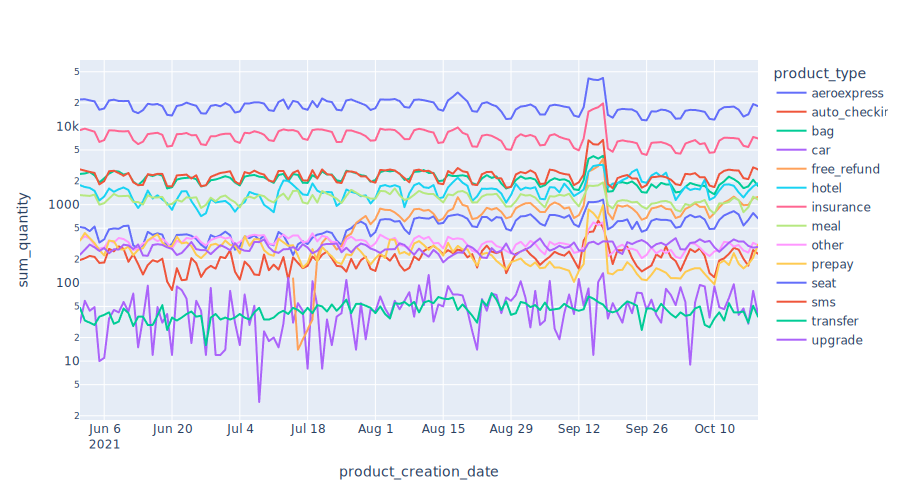

In [17]:
untracked_ids = df.join(
    tracked_pairs.set_index(['product_type', 'ond']).rename(columns={'sum_quantity': 'is_tracked'}),
    on=['product_type', 'ond'],
    how='left'
)['is_tracked'].isna()


df.loc[untracked_ids, 'ond'] = 'XXX-XXX'
df = df.groupby(
    ['product_type', 'product_creation_date', 'ond'])[
    ['sum_price', 'sum_quantity', 'count_rows']
    ].agg('sum').reset_index()

d1 = df.groupby(['product_type', 'product_creation_date'])['sum_quantity'].agg('sum').reset_index()
fig = px.line(d1, x='product_creation_date', y='sum_quantity', color='product_type', log_y=True)
fig.update_layout(width=900, height=500)
fig.show(renderer='svg')

In [18]:
onds = set(df.ond)

tbl_detailed = df.groupby(['product_creation_date', 'product_type', 'ond'])['sum_quantity'].agg(
    sum).unstack().unstack().fillna(0)
tbl_detailed.columns = [tuple(c) for c in tbl_detailed.columns]
pairs_to_drop = tbl_detailed.sum(axis=0)
pairs_to_drop = pairs_to_drop[pairs_to_drop == 0].index
tbl_detailed = tbl_detailed.drop(columns=pairs_to_drop)

# Объединяем всё в итоговую таблицу tbl
tbl = d1.set_index(['product_creation_date', 'product_type']).unstack().fillna(0)
cols = [c[1] for c in tbl.columns]
tbl.columns = cols
tbl_total = tbl.loc[:, cols].sum(axis=1).rename('total')
tbl = pd.concat([tbl_total, segments_sold_per_day, tbl, tbl_detailed], axis=1)

tbl

,total,sum_seg_count,aeroexpress,auto_checkin,bag,car,free_refund,hotel,insurance,meal,...,"(XXX-XXX, other)","(XXX-XXX, prepay)","(XXX-XXX, seat)","(XXX-XXX, sms)","(XXX-XXX, transfer)","(XXX-XXX, upgrade)","(YKS-DME, seat)","(YKS-DME, sms)","(YKS-OVB, seat)","(YKS-OVB, sms)"
product_creation_date,,,,,,,,,,,,,,,,,,,,,
2021-06-01,41215.0,NaN,518.0,196.0,2471.0,31.0,0.0,1774.0,8971.0,1325.0,...,353.0,347.0,818.0,689.0,48.0,202.0,0.0,0.0,53.0,16.0
2021-06-02,41747.0,112233.0,504.0,206.0,2503.0,59.0,0.0,1682.0,9366.0,1307.0,...,394.0,434.0,881.0,634.0,33.0,230.0,0.0,0.0,58.0,16.0
2021-06-03,40439.0,107293.0,459.0,221.0,2612.0,44.0,0.0,1637.0,8950.0,1293.0,...,368.0,374.0,832.0,628.0,31.0,267.0,1.0,0.0,40.0,16.0
2021-06-04,38963.0,171080.0,525.0,215.0,2372.0,49.0,0.0,1503.0,8565.0,1342.0,...,306.0,322.0,787.0,655.0,29.0,253.0,0.0,0.0,53.0,11.0
2021-06-05,29887.0,152038.0,328.0,180.0,1923.0,10.0,0.0,1132.0,6332.0,999.0,...,274.0,264.0,522.0,452.0,37.0,225.0,0.0,0.0,34.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-21,NaN,95803.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-22,NaN,101441.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-23,NaN,57393.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
segments_sold_per_day

product_creation_date
2021-06-02    112233
2021-06-03    107293
2021-06-04    171080
2021-06-05    152038
2021-06-06     87135
               ...  
2021-10-21     95803
2021-10-22    101441
2021-10-23     57393
2021-10-24     53479
2021-10-25     27352
Name: sum_seg_count, Length: 146, dtype: int64

Итоговая таблица содержит информацию по купленным допуслугам в разбивке по продуктам, а также по ond+продуктам.

total -- cумма всех фактов услуг в данный день

sum_seg_count -- количество услуги breakdown, проданной в этот день

строковые колонки (aeroexpress...) -- количество данной услуги в данный день

колонки типа tuple ('XXX-XXX', 'other') --  количество услуги в разбивке по ond



# Добавляем информацию по распродажам в формате fbprophet

In [19]:
sales = pd.DataFrame({
    'holiday': 'sale',
    'ds': pd.to_datetime(
        ['2021-09-14', '2020-06-23', '2020-09-15', '2020-11-10', '2020-12-15', '2021-01-19', '2021-03-23']),
    'lower_window': 0,
    'upper_window': 4,
})
import datetime

sale_dates = []
for _, row in sales.iterrows():
    for shift in range(row.lower_window, row.upper_window + 1):
        sale_dates.append(row.ds + datetime.timedelta(days=shift))

  0%|                                                                                                                                                                                                      | 0/14 [00:00<?, ?it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.05859
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      88       247.927    0.00120912       60.4956    1.37e-05       0.001      155  LS failed, Hessian reset 
      99       247.968   8.31362e-05       75.5973           1           1      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     144       248.027   2.83804e-05       61.6127   4.829e-07       0.001      265  LS failed, Hessian reset 
     199       248.067   2.95847e-06       56.2607           1           1      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     258       248.075   7.83704e-06       76.9503   1.036e-07       0.001      467  LS failed, Hessian reset 
     295       248.076   8.68621e-09       67.7324      0.4811      0.4811      518   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was 

/tmp/ipykernel_57103/3939840630.py:59: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_57103/3939840630.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  7%|█████████████▌                                                                                                                                                                                | 1/14 [00:01<00:25,  1.94s/it]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:D

Initial log joint probability = -3.26734
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      88       253.844   6.51922e-06       83.3224   8.343e-08       0.001      154  LS failed, Hessian reset 
      99       253.845   8.67419e-07        83.358      0.8923      0.8923      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       253.845   1.73316e-08       77.7398      0.8781      0.8781      188   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


 14%|███████████████████████████▏                                                                                                                                                                  | 2/14 [00:03<00:18,  1.56s/it]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.77513
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      65       280.252    0.00180266       89.2459    2.02e-05       0.001      113  LS failed, Hessian reset 
      99       280.468    3.2026e-06        63.253      0.3762      0.3762      167   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     138       280.469   5.53133e-07       75.6061   6.701e-09       0.001      266  LS failed, Hessian reset 
     153        280.47   7.34169e-09       55.9605      0.3141      0.3141      286   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/tmp/ipykernel_57103/3939840630.py:59: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_57103/3939840630.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 21%|████████████████████████████████████████▋                                                                                                                                                     | 3/14 [00:04<00:16,  1.47s/it]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:D

Initial log joint probability = -4.4047
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      56       198.804      0.001306       100.523   1.345e-05       0.001      104  LS failed, Hessian reset 
      99       198.871   1.12108e-07       99.4419      0.3271           1      162   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     116       198.871   9.55583e-09       101.336      0.4035      0.4035      182   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 29%|██████████████████████████████████████████████████████▎                                                                                                                                       | 4/14 [00:05<00:13,  1.38s/it]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.97422
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       226.515   0.000178914       55.0826           1           1      144   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119       226.553   0.000368769       61.2546   4.576e-06       0.001      226  LS failed, Hessian reset 
     175       226.566   2.01736e-06        62.998    3.69e-08       0.001      345  LS failed, Hessian reset 
     186       226.566   6.51036e-09       54.2257    0.008472           1      362   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/tmp/ipykernel_57103/3939840630.py:59: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_57103/3939840630.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 36%|███████████████████████████████████████████████████████████████████▊                                                                                                                          | 5/14 [00:07<00:12,  1.34s/it]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:D

Initial log joint probability = -3.27105
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      90       256.549   0.000637882        78.029    6.17e-06       0.001      148  LS failed, Hessian reset 
      99       256.618   0.000113151         69.43           1           1      159   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     155       256.637   8.33466e-05        83.806   8.154e-07       0.001      265  LS failed, Hessian reset 
     199       256.641   9.33658e-07       89.5698           1           1      322   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     214       256.641   2.40317e-06       89.1152   2.553e-08       0.001      380  LS failed, Hessian reset 
     256       256.641   8.77135e-09        86.326      0.3727           1      437   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was 

 43%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                                            | 6/14 [00:08<00:10,  1.35s/it]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.97833
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       291.473   0.000568532       76.9464      0.5329      0.5329      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     194        291.73   3.83622e-05       84.7037   5.203e-07       0.001      286  LS failed, Hessian reset 
     199       291.731   4.92437e-06       67.0312      0.2522           1      293   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     237       291.734   2.79171e-05       55.3688   3.288e-07       0.001      381  LS failed, Hessian reset 
     279       291.736   3.95665e-08       75.9645        1.36      0.3067      441   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/tmp/ipykernel_57103/3939840630.py:59: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_57103/3939840630.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 50%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                               | 7/14 [00:09<00:09,  1.33s/it]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:D

Initial log joint probability = -3.73536
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      95       271.947   2.81269e-05       70.3351   3.951e-07       0.001      163  LS failed, Hessian reset 
      99       271.948     5.856e-07       50.6374     0.04752           1      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     132       271.948   9.14376e-09       54.2431       0.182       0.182      213   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/tmp/ipykernel_57103/3939840630.py:59: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_57103/3939840630.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 8/14 [00:11<00:07,  1.32s/it]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:D

Initial log joint probability = -3.49255
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        256.81   1.02315e-05       81.6426           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103       256.815   4.71445e-05       70.7703   5.544e-07       0.001      176  LS failed, Hessian reset 
     166       256.817    6.6885e-08       71.7968    8.55e-10       0.001      307  LS failed, Hessian reset 
     169       256.817   2.43921e-08       47.5221      0.4433           1      311   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/tmp/ipykernel_57103/3939840630.py:59: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_57103/3939840630.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 9/14 [00:12<00:06,  1.34s/it]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:D

Initial log joint probability = -5.94384
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      67        241.53   0.000632864       98.7913   6.595e-06       0.001      125  LS failed, Hessian reset 
      99        241.67    0.00356801       91.0899           1           1      164   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102       241.704   0.000555998       97.3029   5.927e-06       0.001      204  LS failed, Hessian reset 
     199       241.757   1.67003e-07       97.0581           1           1      327   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     236       241.768   6.33438e-05        74.363   7.765e-07       0.001      410  LS failed, Hessian reset 
     299       241.772   1.29978e-06       103.575           1           1      485   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/tmp/ipykernel_57103/3939840630.py:59: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_57103/3939840630.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 10/14 [00:13<00:05,  1.33s/it]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:D

Initial log joint probability = -3.00967
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       296.464    3.3089e-05       71.6238           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     126       296.479   5.51991e-05       72.9059   7.021e-07       0.001      205  LS failed, Hessian reset 
     163       296.481   5.90938e-09       69.8743       0.318       0.318      257   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/tmp/ipykernel_57103/3939840630.py:59: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_57103/3939840630.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 11/14 [00:15<00:03,  1.32s/it]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:D

Initial log joint probability = -2.80377
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      96       294.527   1.44922e-05       67.3717   2.117e-07       0.001      176  LS failed, Hessian reset 
      99       294.527   1.47379e-06       47.7529      0.3447      0.3447      180   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     129       294.528   8.40313e-09        58.572     0.03767           1      222   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/tmp/ipykernel_57103/3939840630.py:59: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_57103/3939840630.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 12/14 [00:16<00:02,  1.34s/it]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:D

Initial log joint probability = -5.22701
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       245.932   4.38177e-06       73.9966      0.5493      0.5493      142   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     190       245.946   1.76477e-08       64.8001      0.7377      0.7377      268   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/tmp/ipykernel_57103/3939840630.py:59: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_57103/3939840630.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 13/14 [00:17<00:01,  1.32s/it]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:D

Initial log joint probability = -4.63978
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      65       270.582    0.00238804       85.2754   2.404e-05       0.001      121  LS failed, Hessian reset 
      99       270.853    0.00196515       94.8935           1           1      159   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       270.948   3.72539e-08       78.2258      0.6027      0.6027      285   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     205       270.948   1.52652e-09         91.86      0.2026      0.2026      294   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/tmp/ipykernel_57103/3939840630.py:59: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_57103/3939840630.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:18<00:00,  1.35s/it]


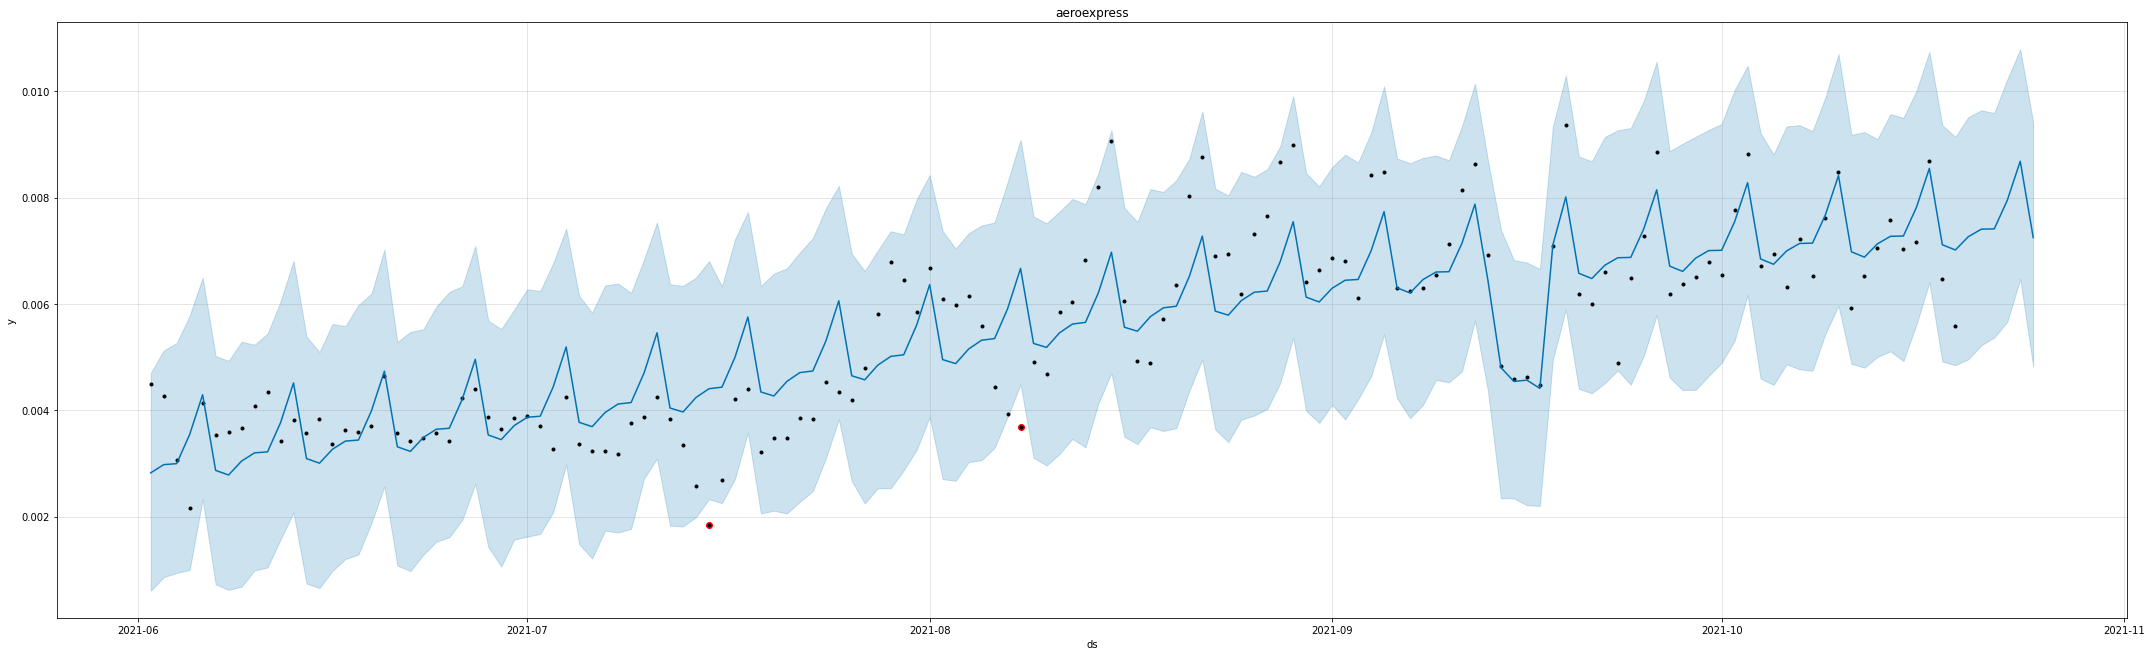

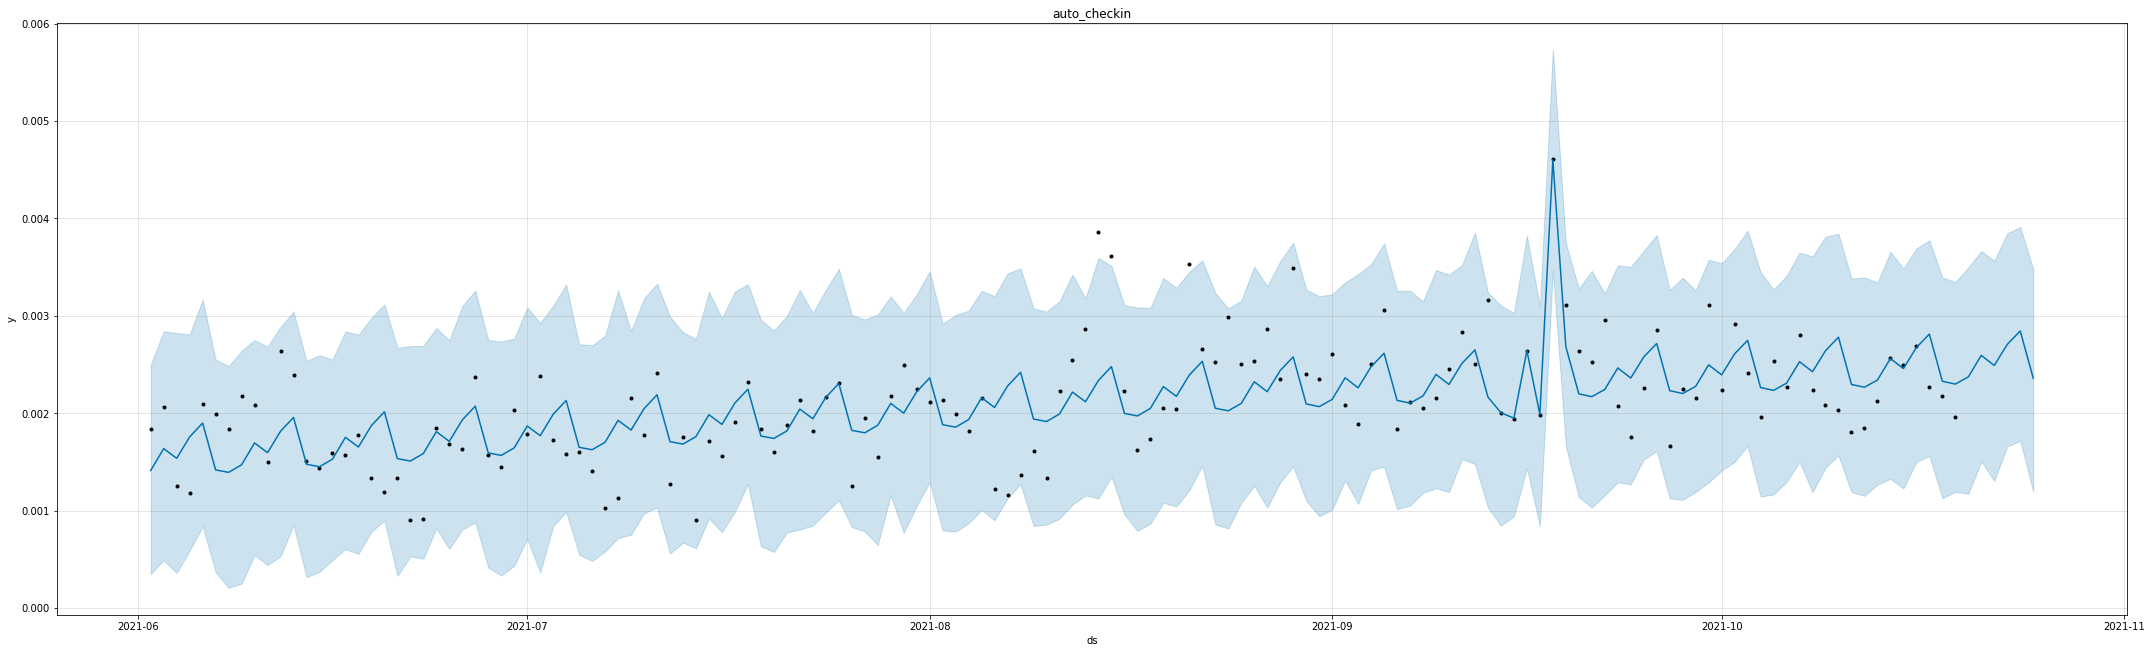

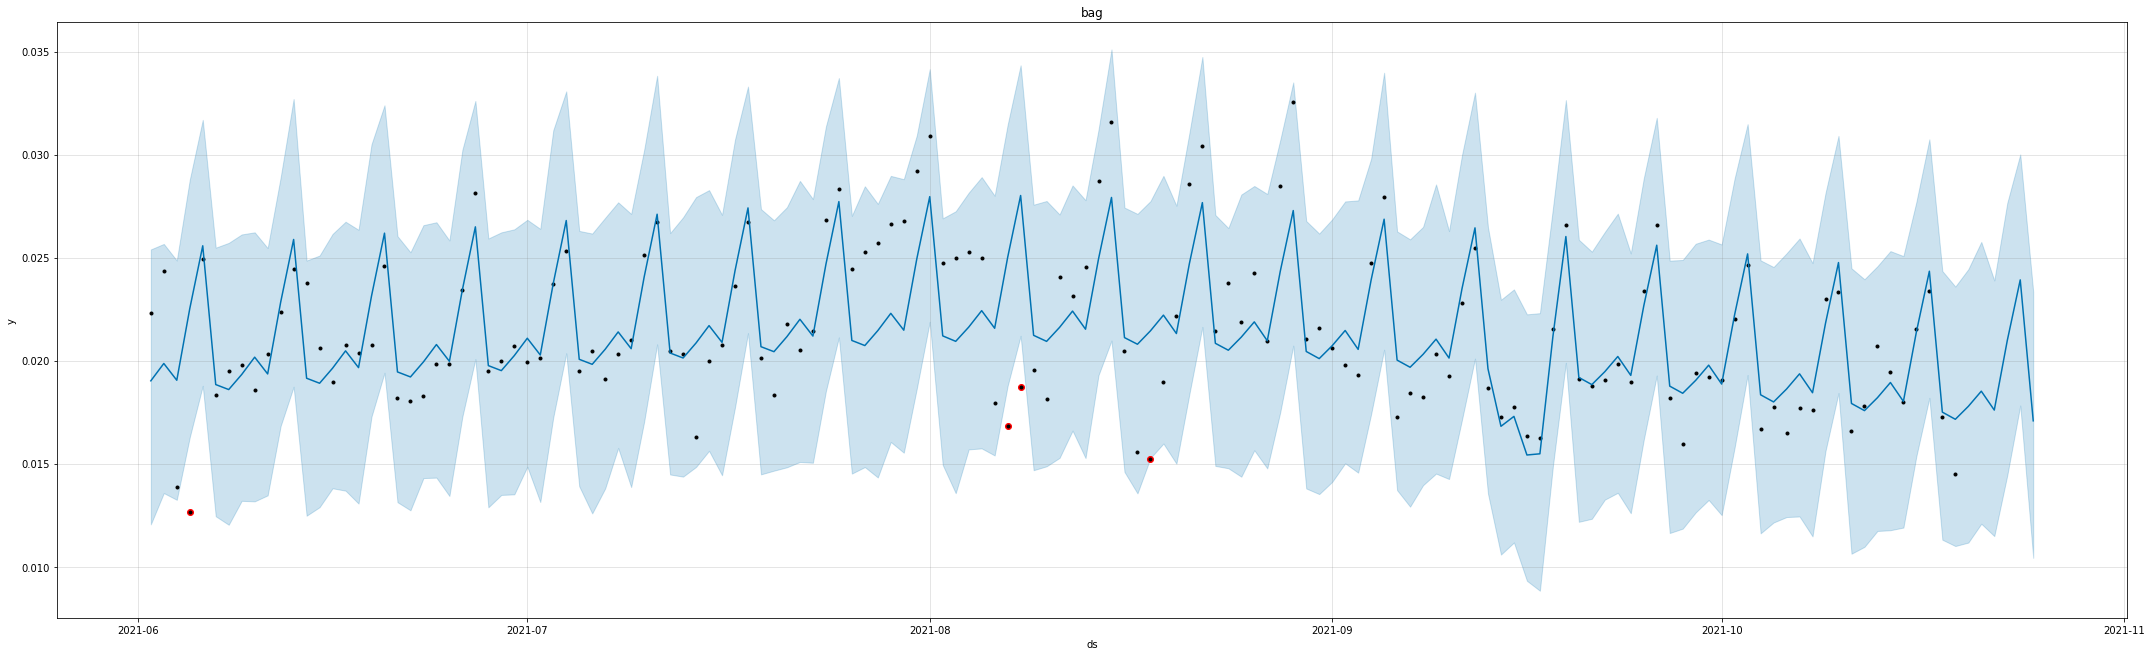

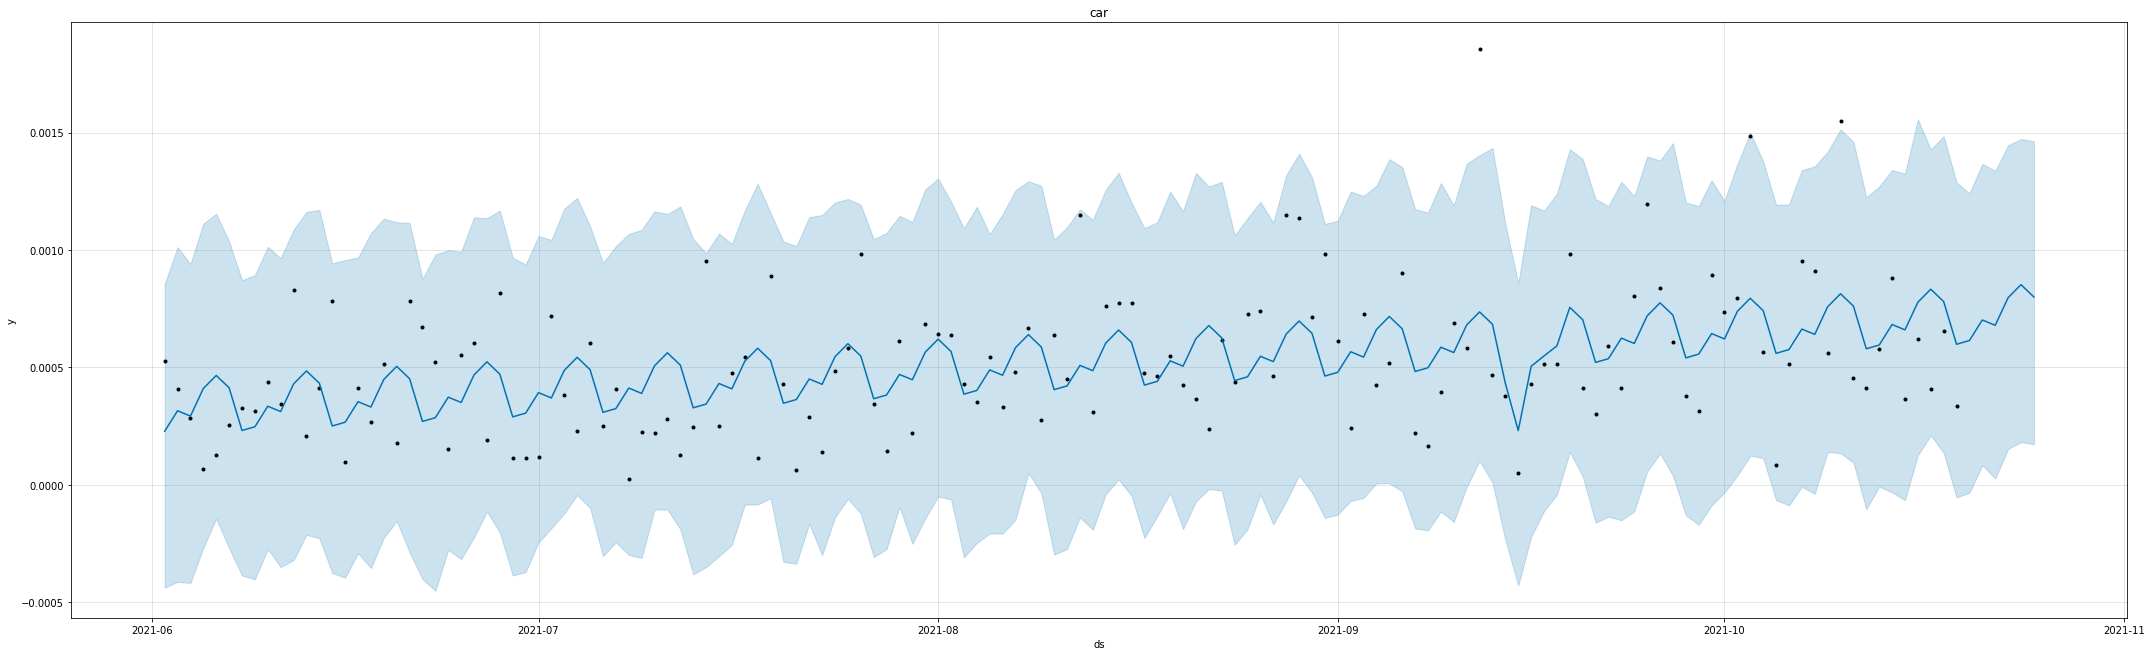

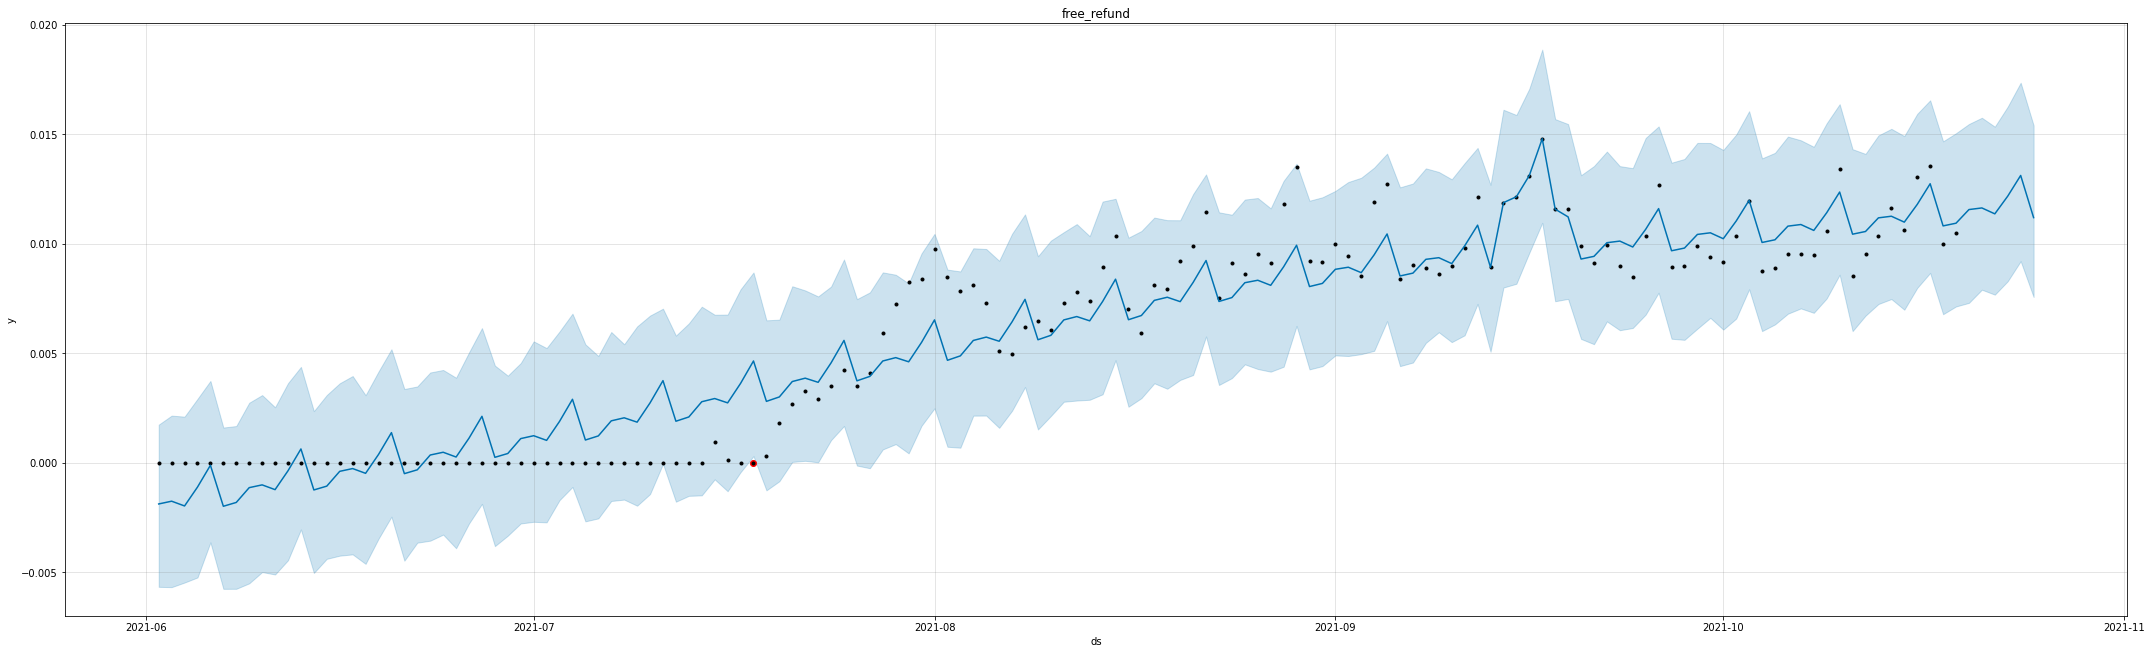

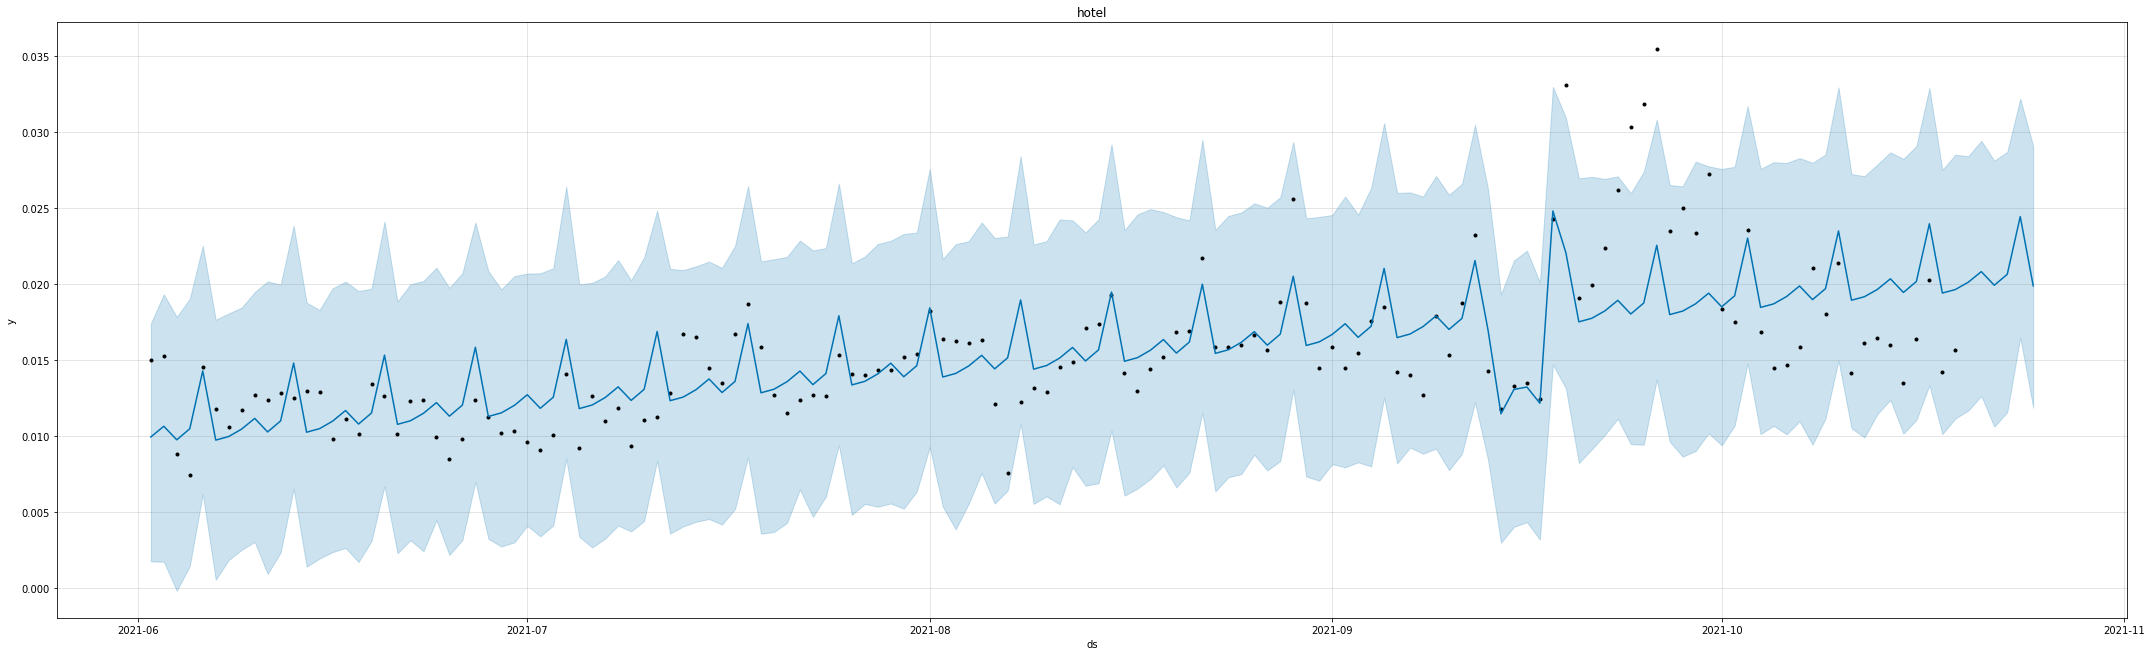

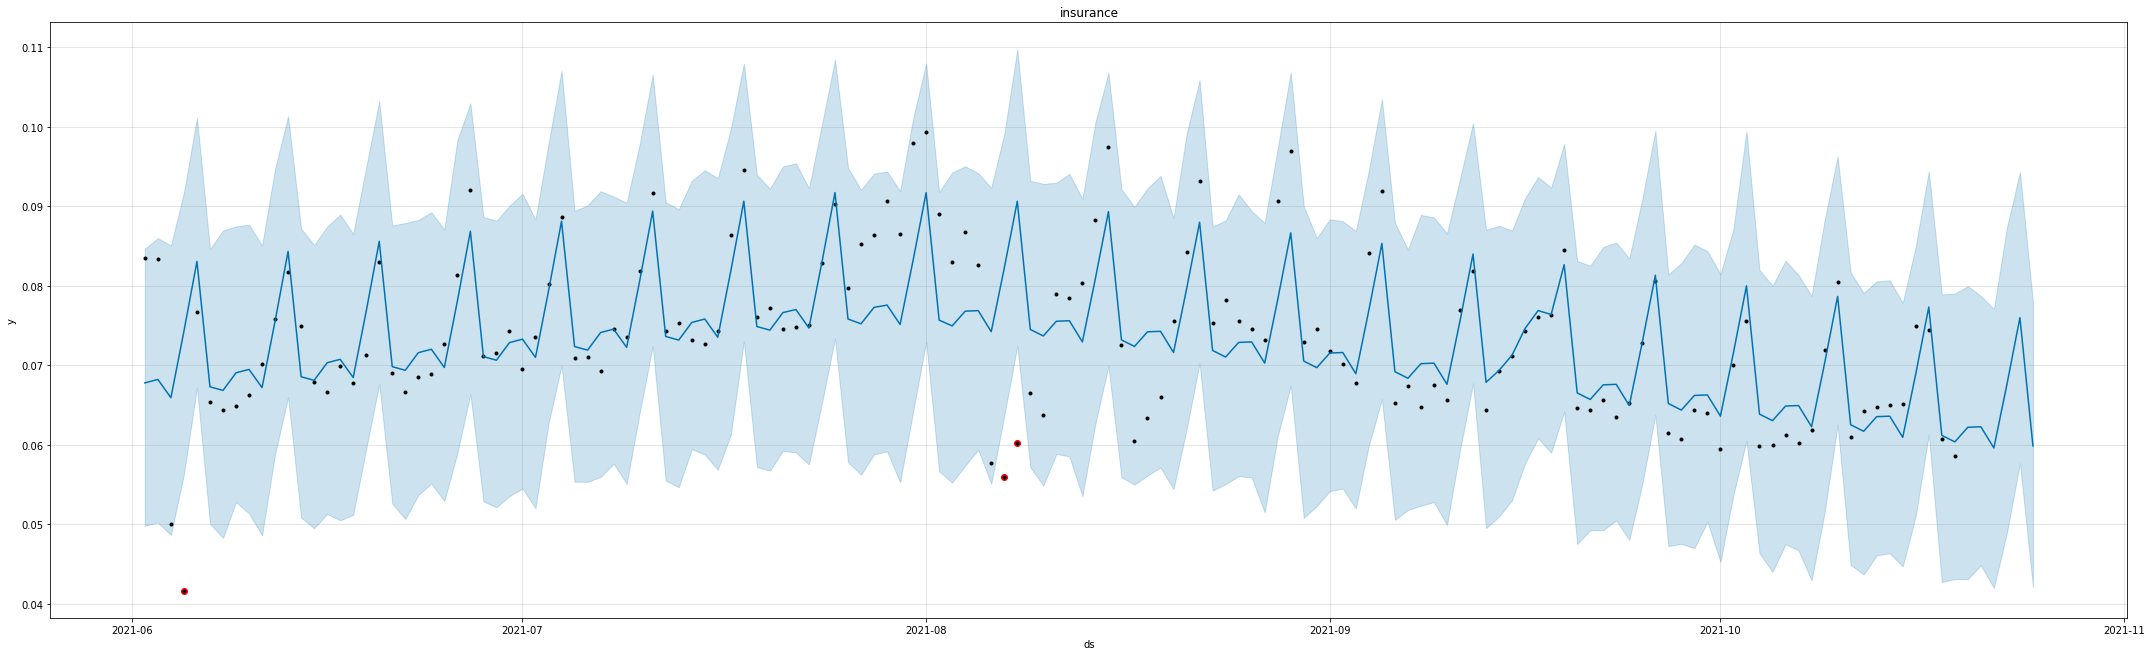

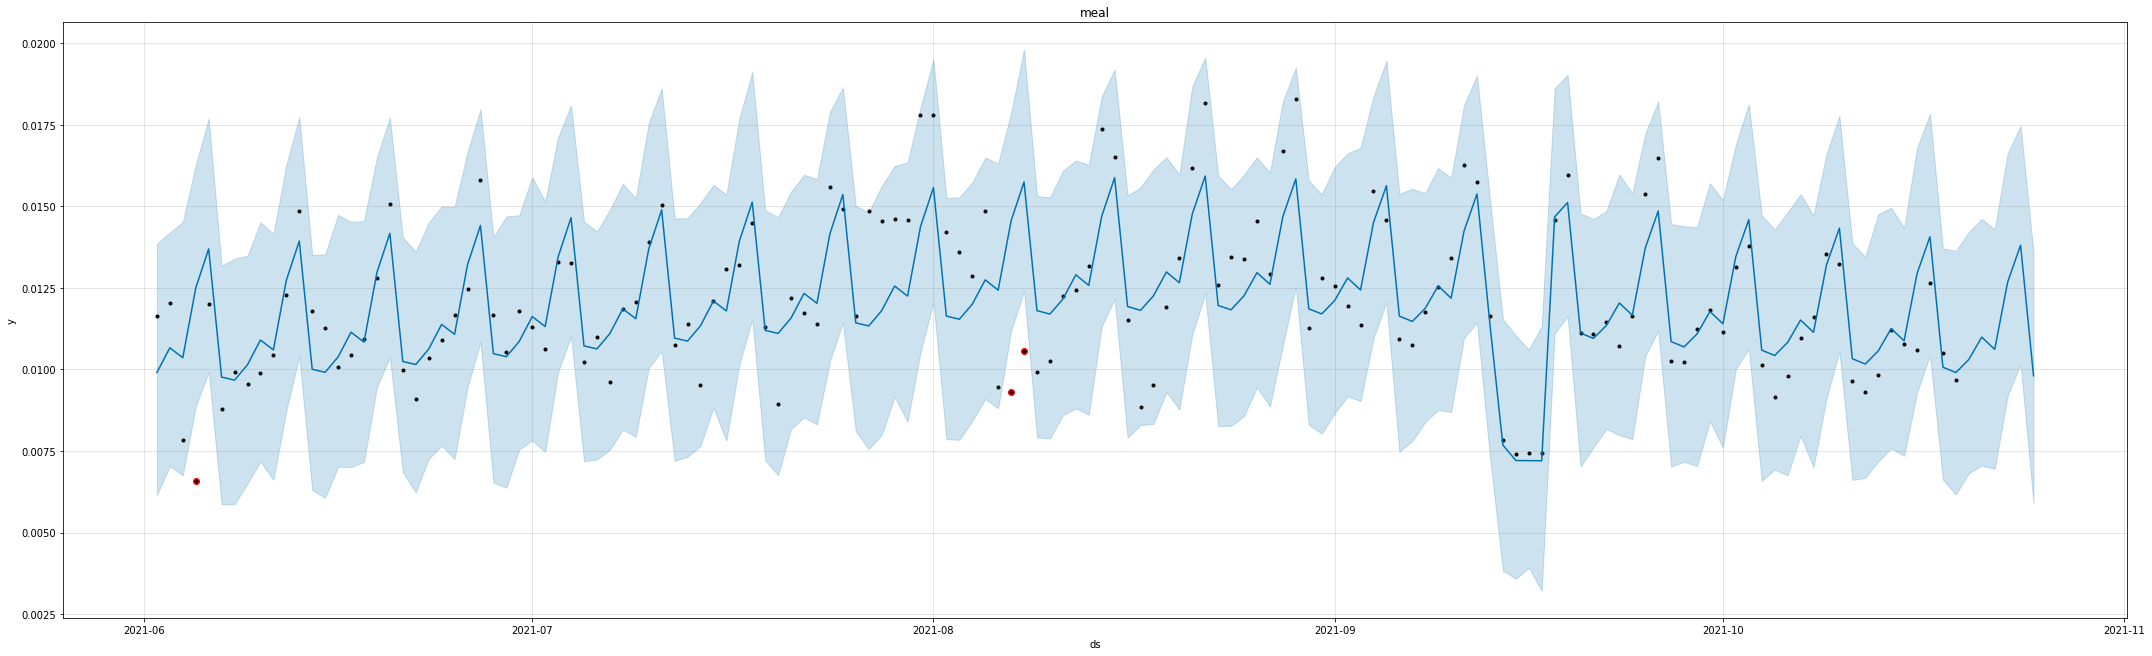

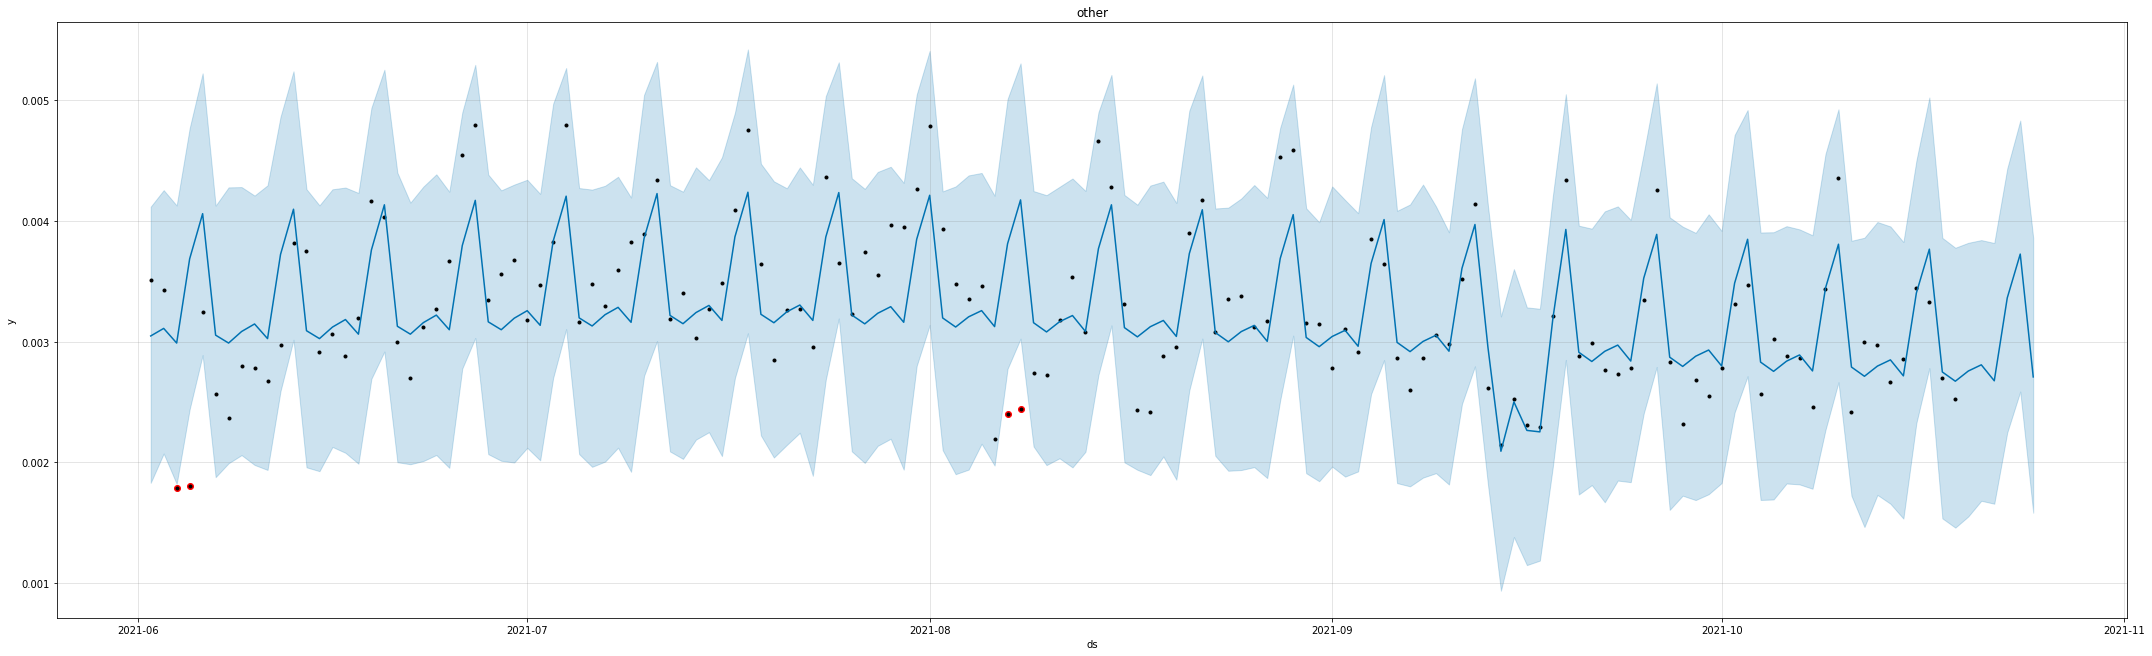

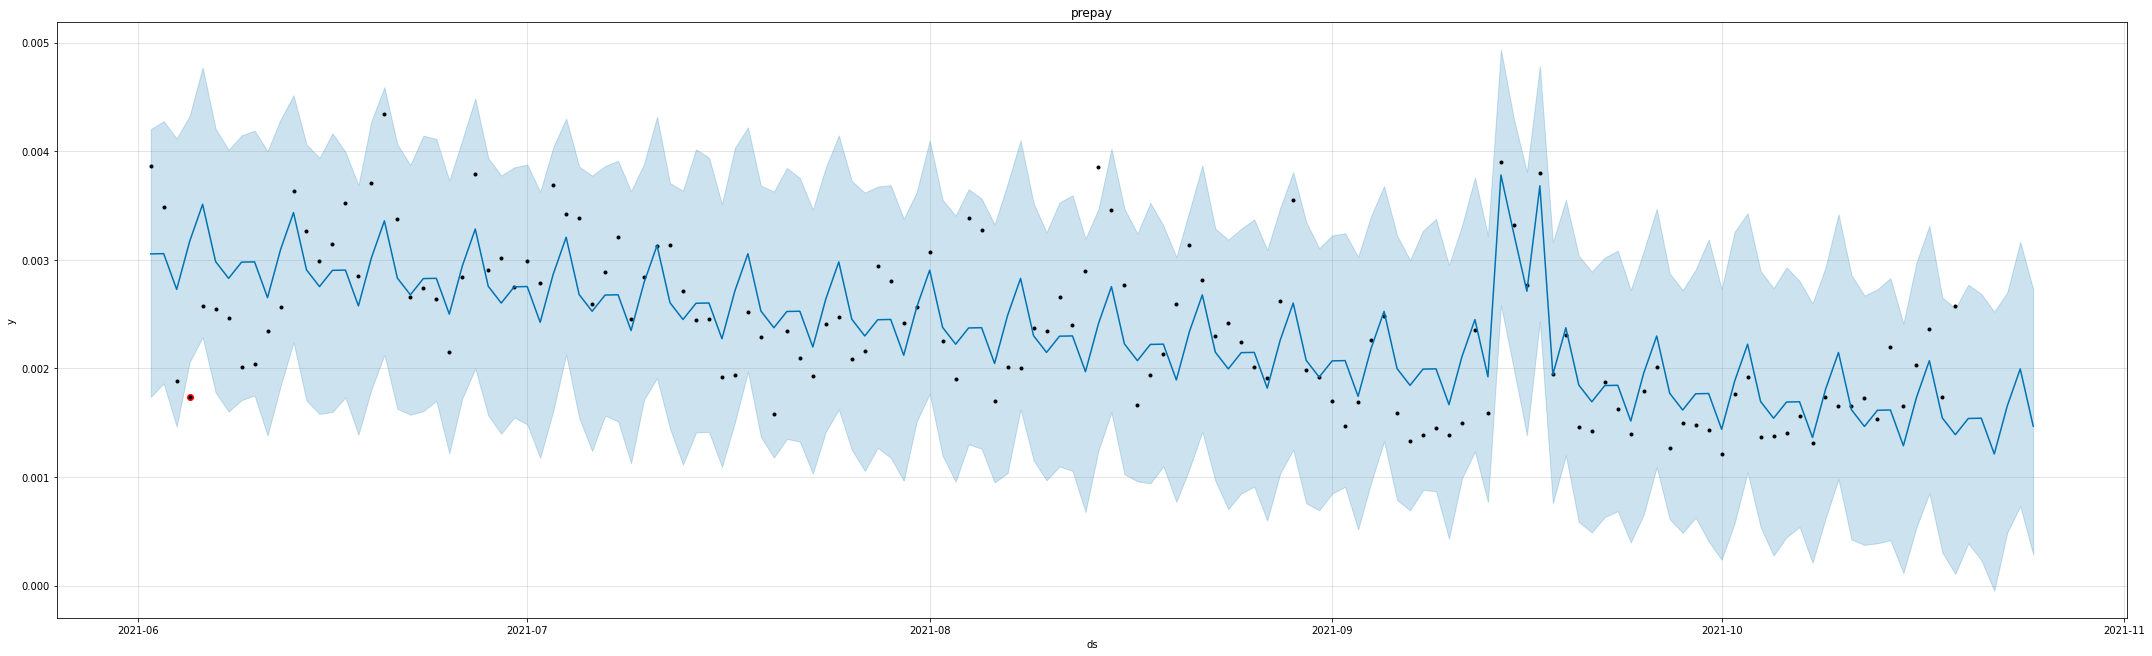

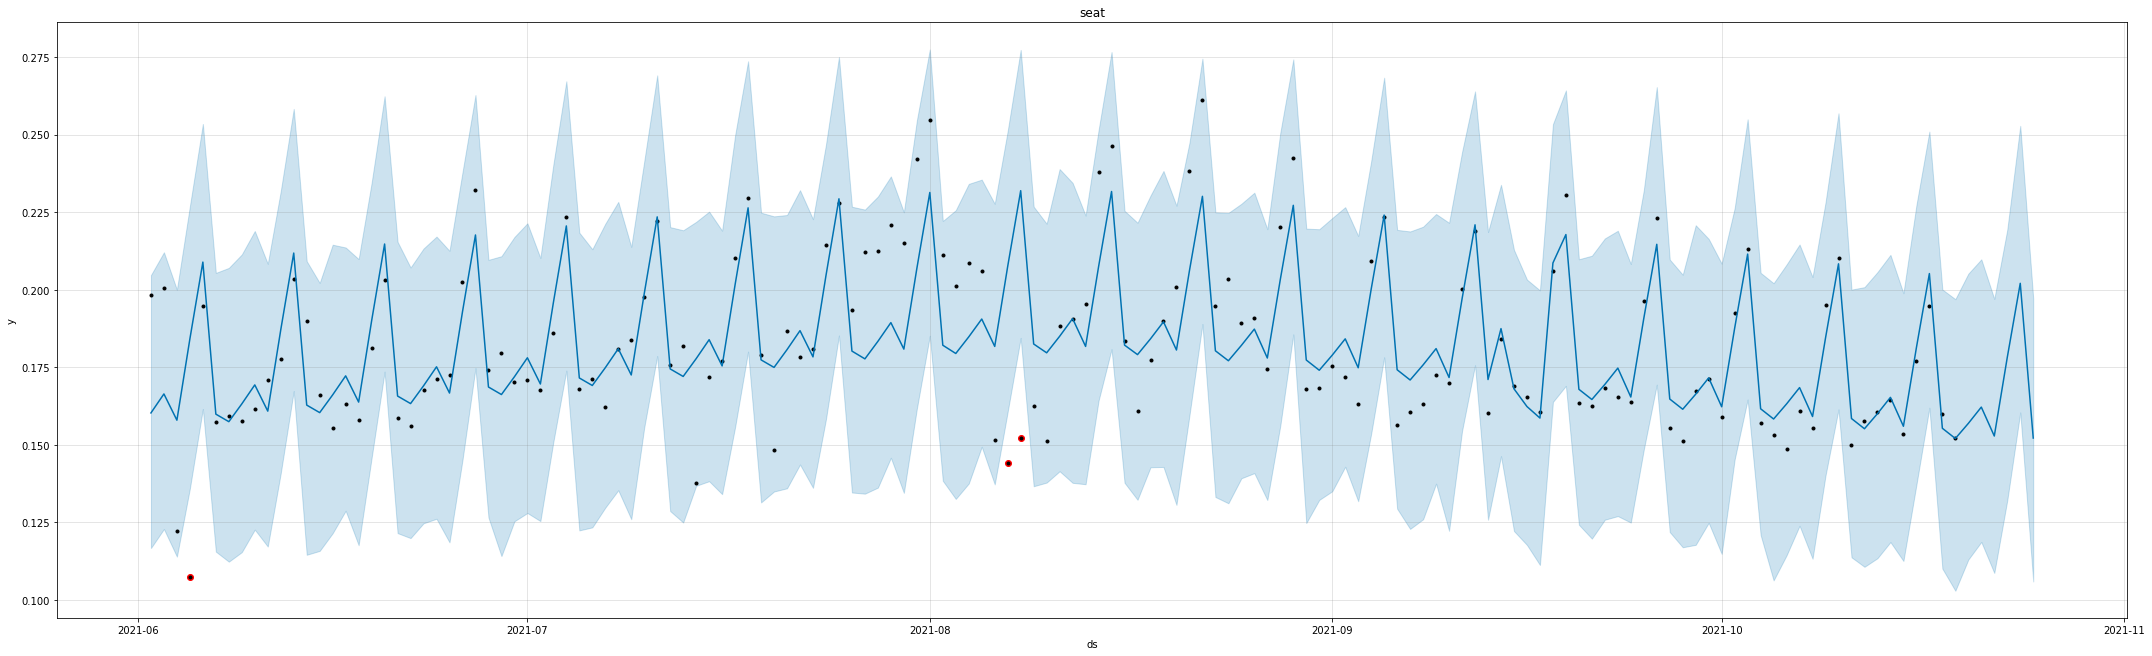

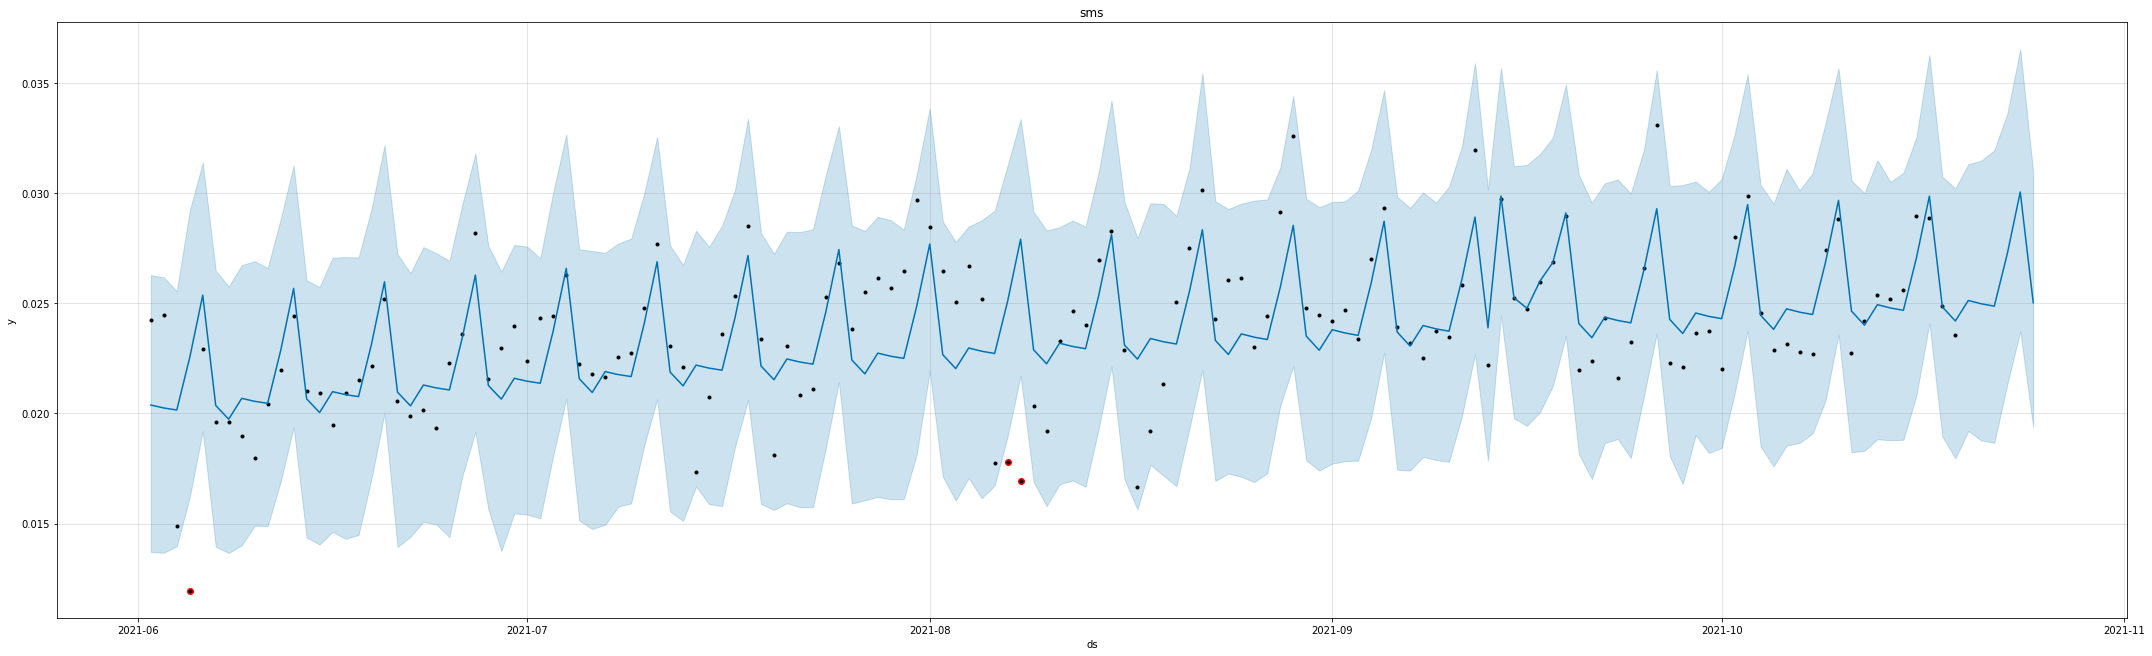

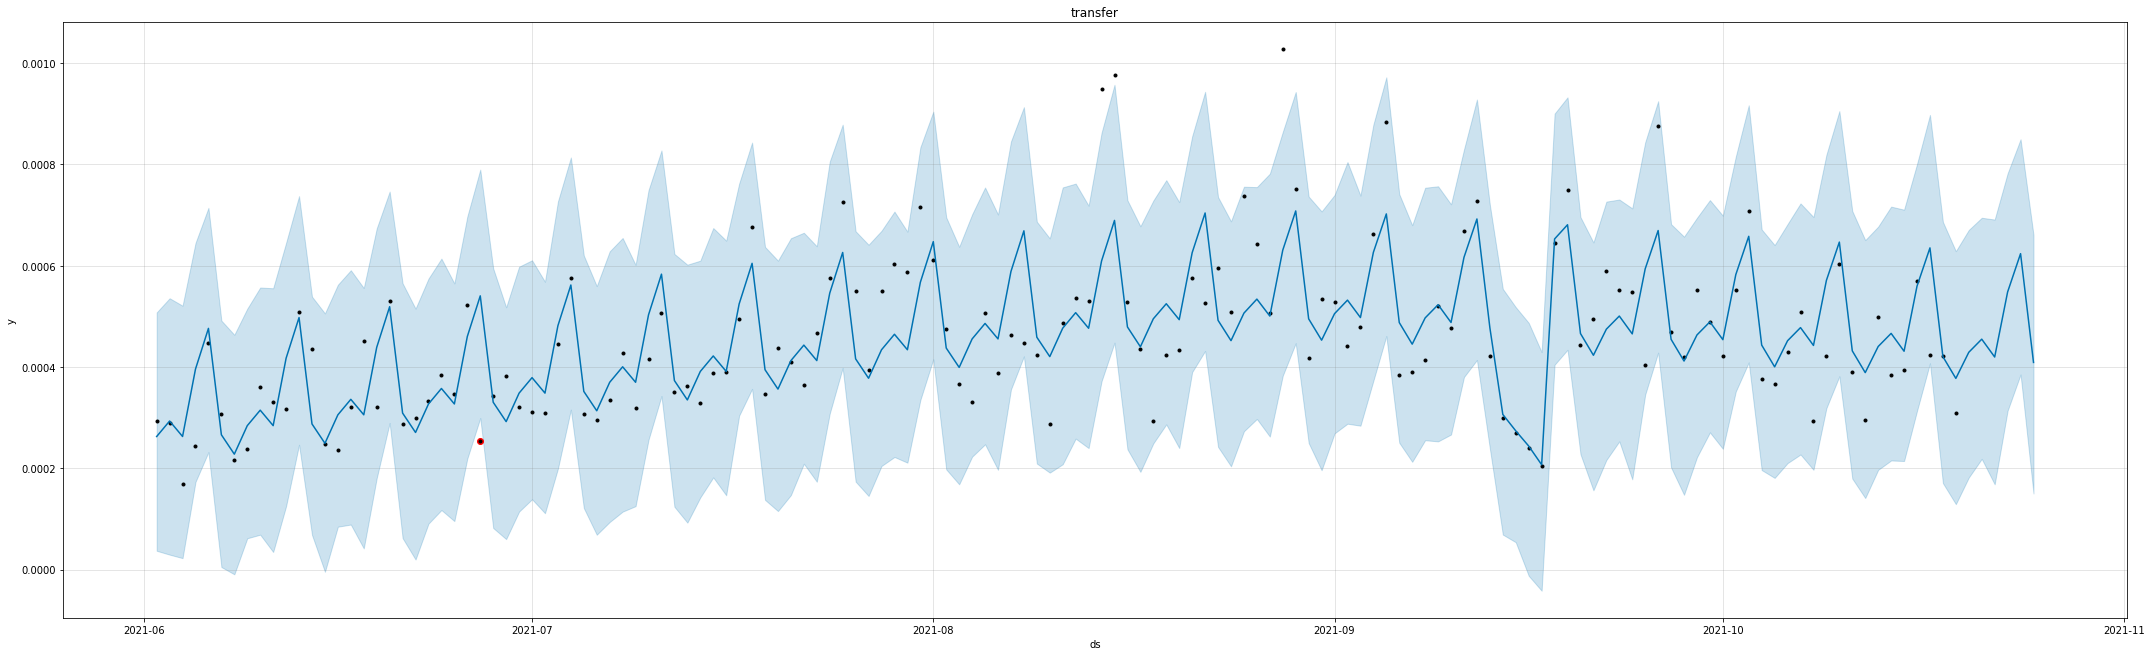

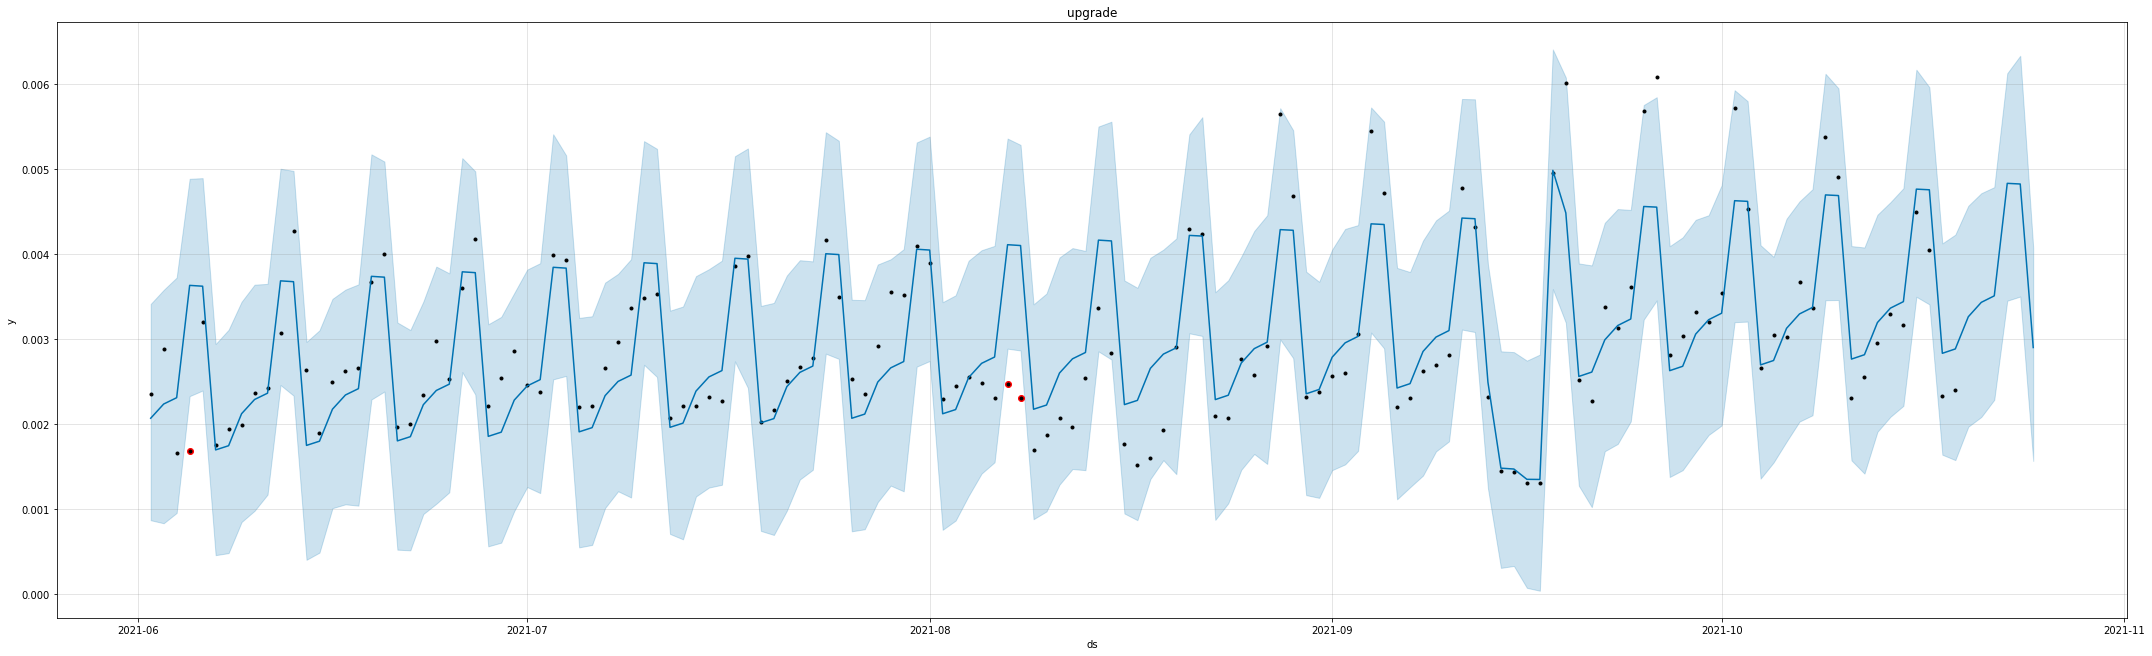

In [11]:
import os
from prophet import Prophet
import matplotlib.pyplot as plt
import tqdm

# FIXME: не считаем пока делализированные 
all_cols = cols  #+list(tbl_detailed.columns)

os.makedirs('./reports', exist_ok=True)
for icol, column in enumerate(tqdm.tqdm(all_cols)):

    if type(column) is str or column[0] == 'XXX-XXX':
        tickets_sold = segments_sold_per_day
    else:
        target_origin, target_destination = column[0].split('-')
        tickets_sold = stats[
            (stats.origin == target_origin) & (stats.destination == target_destination)
            ].groupby('product_creation_date')['sum_seg_count'].agg('sum')

    tickets_sold = tickets_sold.rename('sum_seg_count_direction')
    target = column

    data = tbl[[target]].reset_index().rename(columns={'product_creation_date': 'ds', target: 'y'})
    data = pd.merge(data, tickets_sold, left_on='ds', right_index=True)
    data['actual_count'] = data['y']

    # Предсказываем отношение проданных продуктов к количеству проданных билетов.
    data['y'] = data['y'] / data['sum_seg_count_direction']
    m = Prophet(
        weekly_seasonality=True,
        holidays=sales,
        #     daily_seasonality = True,
        #     yearly_seasonality = True,
        #     n_changepoints = 3,
        interval_width=0.99,
        #     mcmc_samples = 300,

    )

    past = data  #[:-31]
    future = data.drop(columns=['y'])

    m.fit(past)
    forecast = m.predict(future)

    comp = pd.merge(
        forecast[['ds', 'yhat_lower', 'yhat']],
        data,
        left_on='ds',
        right_on='ds')

    # Ratio — во сколько раз y дальше чем предсказательный интервал
    comp['ratio'] = (comp['yhat'] - comp['y']) / (comp['yhat'] - comp['yhat_lower'])

    comp['delta'] = comp.yhat - comp.y

    # Смотрим пока только на отклонения вниз
    anomalies = comp[comp.y < comp.yhat_lower]
    anomalies['is_sale'] = anomalies.ds.isin(sale_dates)
    anomalies['group'] = str(column)
    anomalies.to_csv(f'./reports/{column}.csv', )
    if icol == 0:
        anomalies.to_csv('./reports/all_anomalies.csv')
    else:
        anomalies.to_csv('./reports/all_anomalies.csv', mode='a', header=False)

    plt.figure(figsize=(30, 9))
    ax = plt.gca()
    fig = m.plot(forecast, ax=ax)
    plt.title(column)
    ax.scatter(anomalies.ds, anomalies.y, c='r', marker='o')
    plt.savefig(f'./reports/{column}.png')

